<center>

# **Microproyecto - Arbol de desición** 
# Cáncer de seno
---

</center>




# Importar librerias y datos

In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import StratifiedKFold
# librerías Árboles de Decisión
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

# librerías Gaussian Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import make_scorer

#Cargar data set
from google.colab import files
import io

uploaded = files.upload()
cancer = pd.read_csv(io.BytesIO(uploaded["mammographic_masses.csv"]))

Saving mammographic_masses.csv to mammographic_masses.csv


# 1. Descripción de los datos

In [2]:
cancer

,Mamografia,Edad,Forma,Margen,Densidad,Severidad
0,5,67,3,5,3,1
1,4,43,1,1,76,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,76,1
...,...,...,...,...,...,...
956,4,47,2,1,3,0
957,4,56,4,5,3,1
958,4,64,4,5,3,0
959,5,66,4,5,3,1


### Descripción del data set 


Como se puede evidenciar la base de datos se compone de seis columnas y 961 filas. 




*   La primera columna representa el examen realizado, que es la mamografía, está es de carácter ordinal y va de 1 a 5. 
*   La segunda columna representa la edad del paciente y está representada como un entero, en los años que tuvo el paciente al realizarse el examen.
*   La tercera columna es la forma que tiene el tumor, redondo es 1, ovalado es 2, lobular es 3 e irregular es 4. 
*   La cuarta columna representa el margen de la masa, esta variable es de carácter nominal, el valor de 1 representa que los márgenes están precisamente demarcados con una transición abrupta entre la lesión y el tejido circundante, sin otros cambios no hay nada que sugiere infiltración del tumor; el valor de 2 representa a los márgenes microlobulados, estos son ondulados con ciclos cortos produciendo pequeñas ondulaciones; el valor de 3 son los márgenes oscuros y son aquellos que están ocultos por tejido normal adyacente o interpuesto y no pueden evaluarse mejor; el valor de 4 son los márgenes que están mal definidos, estos presentan una mala definición, lo cual aumenta la sospecha que puede haber infiltraciones por lesión y no por tejido mamario normal sobreimpuesto;  y por último el valor de 5 es para los márgenes espiculados, la lesión  que presenta el tumor se caracteriza por líneas que se irradian desde los márgenes de la masa. 
*   La quinta columna es la densidad que presenta el tumor, y va desde 1 para los que tienen una densidad alta, 2 para los isodensos o sea que tienen una densidad igual, 3 para una densidad baja que no contienen grasa y 4 para los que contienen grasa. 
*   La sexta columna muestra la severidad del tumor, siendo 0 para un tumor benigno y 1 para un tumor maligno. 





 





### **Variable objetivo:** se desea predecir la severidad de los tumores, si es benigno o maligno. 

## Preprocesamiento 

In [3]:
# Verificar si el dataset tiene valores NaN
hayNaN = pd.isna(cancer)

contador = 0 

for i in cancer:
  for j in hayNaN[i]:
    if j == True:
      contador +=1

print('La cantidad de valores NAN en el dataset es: {}'.format(contador))

La cantidad de valores NAN en el dataset es: 0


Se realizó un preprocesamiento, el cual consta en quitar la columna de la mamografía, ya que está no le brinda información para la clasificación que se va a realizar de la severidad de los tumores. 

In [4]:
cancer1 = cancer.drop(['Mamografia'], axis=1)
cancer1

,Edad,Forma,Margen,Densidad,Severidad
0,67,3,5,3,1
1,43,1,1,76,1
2,58,4,5,3,1
3,28,1,1,3,0
4,74,1,5,76,1
...,...,...,...,...,...
956,47,2,1,3,0
957,56,4,5,3,1
958,64,4,5,3,0
959,66,4,5,3,1


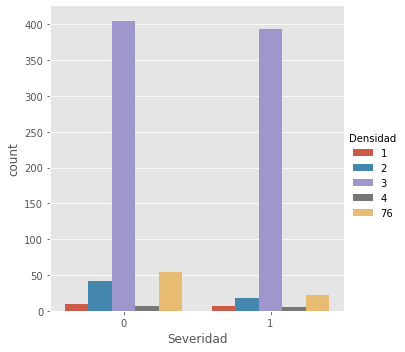

In [5]:
g = sb.catplot(x='Severidad', data=cancer1, hue='Densidad', kind="count")

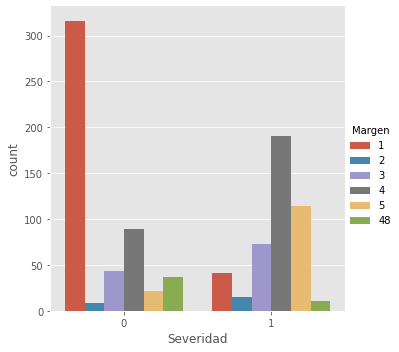

In [6]:
g = sb.catplot(x='Severidad', data=cancer1, hue='Margen', kind="count")

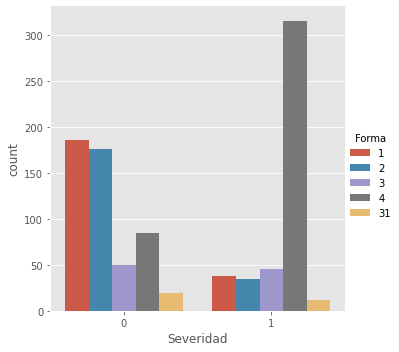

In [7]:
g = sb.catplot(x='Severidad', data=cancer1, hue='Forma', kind="count")

Como se puede observar de los histogramas la base de datos presenta algunos valores que no le corresponden, ya que al ser solo valores ordinales y nominales que van desde el 1 hasta el 4 o 5, no tiene sentido que haya valores mayores a 4 o 5. Por lo que se va a realizar una limpieza a la base de datos. 

In [8]:
filas_forma =  cancer1[cancer1['Forma'] > 4].index
cancer1.drop(filas_forma, inplace=True)

filas_margen =  cancer1[cancer1['Margen'] > 5].index
cancer1.drop(filas_margen, inplace=True)

filas_densidad =  cancer1[cancer1['Densidad'] > 4].index
cancer1.drop(filas_densidad, inplace=True)

cancer1

,Edad,Forma,Margen,Densidad,Severidad
0,67,3,5,3,1
2,58,4,5,3,1
3,28,1,1,3,0
8,57,1,5,3,1
10,76,1,4,3,1
...,...,...,...,...,...
956,47,2,1,3,0
957,56,4,5,3,1
958,64,4,5,3,0
959,66,4,5,3,1


Vamos a observar la cantidad de tumores benignos y malignos que hay en el data set.

In [9]:
cancer1.groupby('Severidad').size()

Severidad
0    428
1    408
dtype: int64

In [10]:
#Creando los pesos con respecto a la clase con mayor tamaño de datos
w = cancer1.groupby('Severidad').size().iloc[0]/cancer1.groupby('Severidad').size().iloc[1]
w

1.0490196078431373

**Variable objetivo**: Hay 428 tumores benignos (label 0) y 408 tumores malignos (label 1). Al ser cantidades tan iguales los árboles de decisión no van a tener mucho sesgo. Esto se puede evidenciar en el siguiente gráfico.

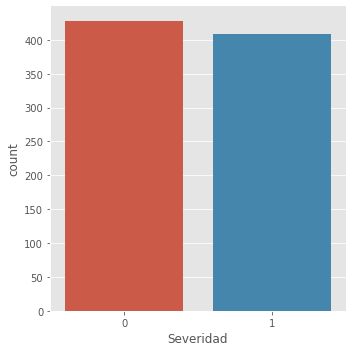

In [11]:
g = sb.catplot(x='Severidad', data=cancer1, kind="count")

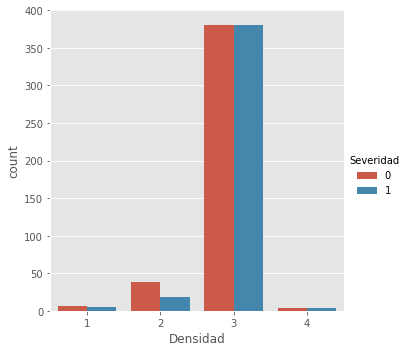

In [12]:
g = sb.catplot(x='Densidad', data=cancer1, hue='Severidad', kind="count")

Como se puede apreciar en el histograma, no se puede encontrar una gran diferencia entre tumores malignos y benignos mirando la densidad de estos, ya que la cantidad de datos es muy similar en las dos clases. Pero si podemos encontrar que la gran mayoría de tumores isodensos son tumores benignos. 

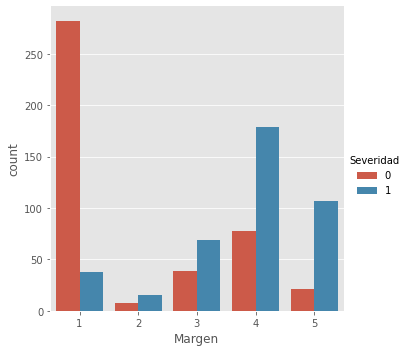

In [13]:
g = sb.catplot(x='Margen', data=cancer1, hue='Severidad', kind="count")

Del anterior histograma se puede observar que la gran mayoría de tumores con márgenes bien definidos hacen parte de los benignos, mientras los que presentan márgenes que no están muy bien definidos y espiculados la gran mayoría son tumores malignos.  

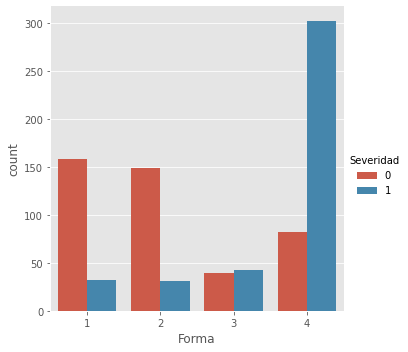

In [14]:
g = sb.catplot(x='Forma', data=cancer1, hue='Severidad', kind="count")

Evidenciamos que los tumores con una forma irregular son principalmente tumores malignos, mientras que los que son redondos u ovalados son principalmente benignos. 

In [15]:
cancer1.drop(['Forma','Margen','Densidad','Severidad'], axis=1).describe()

,Edad
count,836.000000
mean,55.473684
std,15.135334
min,5.000000
25%,45.000000
50%,57.000000
75%,66.000000
max,96.000000


Para utilizar la edad en los árboles se va a mapear la edad en cinco grupos, lo cuales van a tener el rango de:
 
*   Menor o igual a 11 años (Infancia) = 1
*   Mayor a 12 años y menor o igual a 18 años (Adolescencia) = 2
*   Mayor a 19 años y menor o igual a 26 años (Juventud) = 3 
*   Mayor a 27 años y menor o igual a 59 años (Adultez) = 4 
*   Mayor a 60 años (Persona Mayor) = 5









In [16]:
# Mapping edad en la que llegaron al billboard
cancer1_edad = cancer1['Edad']

cancer1.loc[ cancer1_edad <= 11, 'Edad']	= 1
cancer1.loc[(cancer1_edad >= 12) & (cancer1_edad <= 18), 'Edad'] = 2
cancer1.loc[(cancer1_edad >= 19) & (cancer1_edad <= 26), 'Edad'] = 3
cancer1.loc[(cancer1_edad >= 27) & (cancer1_edad <= 59), 'Edad'] = 4
cancer1.loc[ (cancer1_edad >= 60) , 'Edad'] = 5

cancer1['Edad'] = cancer1['Edad'].astype(int)

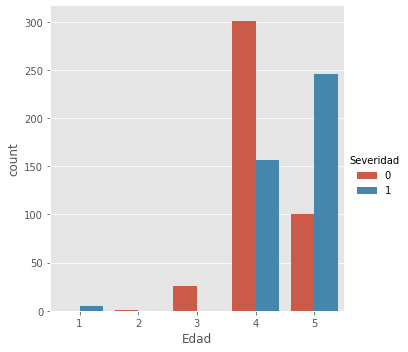

In [17]:
g = sb.catplot(x='Edad', data=cancer1, hue='Severidad', kind="count")

Como se puede ver del histograma la mayoría de los casos de tumores ocurren en el grupo de adultez y de personas mayores. 

# 2. Técnica DJ

In [18]:
#Mezclar datos
cancer_encoded = cancer1.sample(frac=1).reset_index(drop=True)

X = cancer_encoded.drop(['Severidad'], axis=1)
y = cancer_encoded['Severidad'] 


X = np.array(X)
y = np.array(y)

#### Entropy

In [19]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # Numero de "folds: Subconjuntos" en que se dividen los datos de entrenamiento,

                                                              # Lo prueba con n-1 holds restantnes,
accuracies = list()
max_attributes = len(list(cancer_encoded))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={0:1, 1:w}) # Por defecto todas las clases tienen peso 1
                                                                        # tambien se puede usar 'balanced'
    for train_index, valid_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[valid_index]    #Validación cruzada.
        y_train, y_test = y[train_index], y[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.769033
         2          0.797820
         3          0.796586
         4          0.806182
         5          0.816954


#### Gini

In [20]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1) # Numero de "folds: Subconjuntos" en que se dividen los datos de entrenamiento,
                                                                # Lo prueba con n-1 holds restantnes,
accuracies = list()
max_attributes = len(list(cancer_encoded))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={0:1, 1:w}) # Por defecto todas las clases tienen peso 1
                                                                        # tambien se puede usar 'balanced'
    for train_index, valid_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[valid_index]    #Validación cruzada.
        y_train, y_test = y[train_index], y[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.769033
         2          0.797820
         3          0.796586
         4          0.806182
         5          0.816954


Al observar los criterios de Gini y de entropía obtenidos, se puede observar que los dos no presentan una gran diferencia entre sí. Dando un desempeño muy similar en la exactitud. 

Se puede observar tambien que la mayor valor de entropia y del indice Gini se obtiene en el nivel 5, por lo que se puede afirmar que hay una  buena mezcla de las clases y hay una mayor ganancia de información.

# 3. Datos de entrenamiento y de prueba

Haciendo la prueba con distintos porcentajes de los datos para entrenamiento y para prueba notamos que para el caso de 80% de los datos para entrenamiento obtiene los mismos resultados de exactitud que usando el 90%, sin embargo da mucha más información un 20% de los datos para prueba que un 10%. De modo que es más útil usar la proporción 20-80 para prueba entrenamiento respectivamente

### 70% de entrenamiento 30% de prueba


In [21]:
# Dividimos los datos para entrenamiento y prueba
X = cancer_encoded.drop(['Severidad'], axis=1)
y = cancer_encoded['Severidad']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,    #80% entrenamineto, 20% prueba 
                                                    stratify = y,
                                                    random_state = 1)
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0    299
1    286
dtype: int64

In [22]:
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced') 
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))

y_pred_test = decision_tree.predict(X_test)

#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

Exactitud con datos de entrenamiento: 0.82
Exactitud con datos de pruebas: 0.81


### 80% de entrenamiento 20% de prueba


In [23]:
# Dividimos los datos para entrenamiento y prueba
X = cancer_encoded.drop(['Severidad'], axis=1)
y = cancer_encoded['Severidad']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,    #80% entrenamineto, 20% prueba 
                                                    stratify = y,
                                                    random_state = 1)
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0    342
1    326
dtype: int64

In [24]:
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced') 
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))

y_pred_test = decision_tree.predict(X_test)

#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

Exactitud con datos de entrenamiento: 0.82
Exactitud con datos de pruebas: 0.81


### 90% de entrenamiento 10% de prueba


In [25]:
# Dividimos los datos para entrenamiento y prueba
X = cancer_encoded.drop(['Severidad'], axis=1)
y = cancer_encoded['Severidad']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.1,    #80% entrenamineto, 20% prueba 
                                                    stratify = y,
                                                    random_state = 1)
conteo = X_train.copy()
conteo['label'] = y_train
conteo.groupby('label').size()

label
0    385
1    367
dtype: int64

In [26]:
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced') 
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))

y_pred_test = decision_tree.predict(X_test)

#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

Exactitud con datos de entrenamiento: 0.82
Exactitud con datos de pruebas: 0.81


# 4. Clasificación de variables

### Gráfica de correlación de Pearson

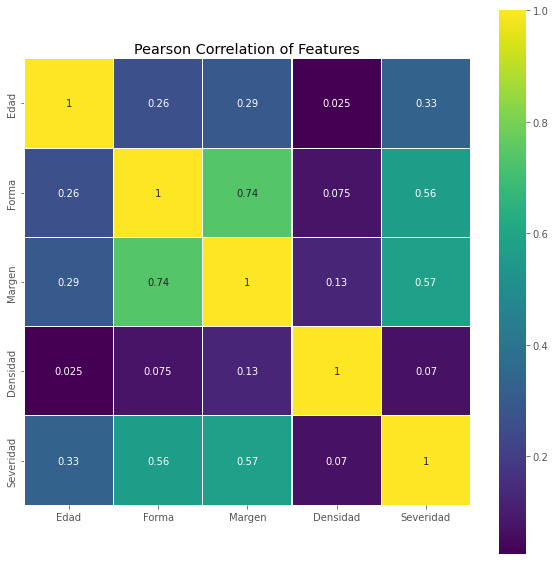

In [27]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features')
sb.heatmap(cancer_encoded.astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)

Observando el diagrama de Pearson podemos notar que la variable densidad es la que presenta menor correlación con las demás, obteniendo valores de 0.07 con respecto a nuestra variable objetivo, mientras que las variables Edad, Forma y Margen presentan correlaciones entre 0.33, 0.56 y 0.57 respectivamente.   

### Matriz de correlación de Cramer V
Para datos categóricos

In [28]:
data_encoded = cancer_encoded.copy()

In [29]:
from scipy.stats import chi2_contingency

def cramers_V(var1, var2):
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape) - 1
  return (stat/(obs*mini))

In [30]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2])
    col.append(round(cramers,2))
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)


df

,Edad,Forma,Margen,Densidad,Severidad
Edad,1.00,0.04,0.04,0.00,0.17
Forma,0.04,1.00,0.21,0.01,0.34
Margen,0.04,0.21,1.00,0.01,0.35
Densidad,0.00,0.01,0.01,1.00,0.01
Severidad,0.17,0.34,0.35,0.01,1.00


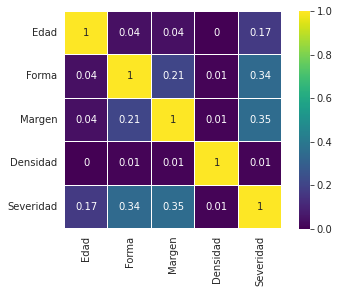

In [31]:
with sb.axes_style("white"):
  ax = sb.heatmap(df,
                  vmin=0.,
                  vmax=1,
                  cmap=colormap,
                  annot=True,
                  linewidths=0.1,
                  square=True)

plt.show()

Al observar el gráfico de Cramer, podemos notar que la variable de densidad es la que presenta un valor más cercano a 0, evidencia que está no presenta ninguna relación con respecto a las otras variables. Otra variable, la cual no tiene mucha relación con las demás variables es la de la edad de los pacientes, teniendo valores de 0, 0.04 y 0.17, valores muy cercanos a cero. 


Al observar los gráficos de Pearson y de Cramer V, se puede notar que las variables de ‘Densidad’ y ‘Edad’ son las mejores opciones para utilizar en el árbol de decisión. 

## SelecKBest

¿Qué variables tienen mayor impacto qué otras a la variable objetivo?

In [32]:
#Mezclar datos, aunque ya se mezclaron mas arriba
cancer_encoded=cancer_encoded.sample(frac=1).reset_index(drop=True)

#Todos los datos excepto la caracteristica objetivo.
X = cancer_encoded.drop(['Severidad'], axis=1)

#CARACTERÍSTICA OBJETIVO
y = cancer_encoded['Severidad']
 
best=SelectKBest(k=len(list(cancer1))-1)

X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['Edad', 'Forma', 'Margen', 'Densidad'], dtype='object')


En conclusión, al usar la gráfica de correlación de Pearson, la matriz de correlación de Crammer V y la técnica SeleckBest, se puede observar que coinciden en que las variables en orden de importancia de clasificación para el árbol de decisiones son: Edad, Forma, Margen y Densidad

# 5. Profundidad del árbol de decisiones

### Prueba de exactitud para distintas profundidades del árbol de decisiones

In [33]:
print("Profundidad = 1")
depth = 1
decision_tree = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=5, max_depth = depth, class_weight='balanced')
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)
#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))
y_pred_test = decision_tree.predict(X_test)
#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))
print("")

print("Profundidad = 2")
depth = 2
decision_tree = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=5, max_depth = depth, class_weight='balanced') 
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)
#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))
y_pred_test = decision_tree.predict(X_test)
#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))
print("")

print("Profundidad = 3")
depth = 3
decision_tree = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=5, max_depth = depth, class_weight='balanced') 
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)
#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))
y_pred_test = decision_tree.predict(X_test)
#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))
print("")

print("Profundidad = 4")
depth = 4
decision_tree = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=5, max_depth = depth, class_weight='balanced') 
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)
#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))
y_pred_test = decision_tree.predict(X_test)
#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))
print("")

print("Profundidad = 5")
depth = 5
decision_tree = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=5, max_depth = depth, class_weight='balanced') 
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)
#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))
y_pred_test = decision_tree.predict(X_test)
#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))


Profundidad = 1
Exactitud con datos de entrenamiento: 0.78
Exactitud con datos de pruebas: 0.75

Profundidad = 2
Exactitud con datos de entrenamiento: 0.80
Exactitud con datos de pruebas: 0.80

Profundidad = 3
Exactitud con datos de entrenamiento: 0.80
Exactitud con datos de pruebas: 0.79

Profundidad = 4
Exactitud con datos de entrenamiento: 0.82
Exactitud con datos de pruebas: 0.81

Profundidad = 5
Exactitud con datos de entrenamiento: 0.82
Exactitud con datos de pruebas: 0.81


Para distintas profundidades del árbol de decisiones se puede observar que a partir de una profundidad de 4 se obtienen buenos valores de exactitud en ambos conjuntos de datos, y procurando la simplicidad del modelo, se elige una profundidad de 4 para el árbol de decisiones

# 6. Árbol de decisiones

In [34]:
print("mínimo de muestras por nodo > 5 y mínimo de muestras por hoja > 5")
depth = 4
decision_tree = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=8, max_depth = depth, class_weight='balanced') 
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)
#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))
y_pred_test = decision_tree.predict(X_test)
#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))
print("")

print("mínimo de muestras por nodo > 5 y mínimo de muestras por hoja = 5")
depth = 4
decision_tree = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=5, max_depth = depth, class_weight='balanced') 
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)
#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))
y_pred_test = decision_tree.predict(X_test)
#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))
print("")

print("mínimo de muestras por nodo = 5 y mínimo de muestras por nodo > 5")
depth = 4
decision_tree = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=5, min_samples_leaf=10, max_depth = depth, class_weight='balanced') 
# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)
#Porcentaje de Exactitud con los datos de entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))
y_pred_test = decision_tree.predict(X_test)
#Porcentaje de Exactitud con pruebas
acc_test = accuracy_score(y_test, y_pred_test)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

mínimo de muestras por nodo > 5 y mínimo de muestras por hoja > 5
Exactitud con datos de entrenamiento: 0.82
Exactitud con datos de pruebas: 0.81

mínimo de muestras por nodo > 5 y mínimo de muestras por hoja = 5
Exactitud con datos de entrenamiento: 0.82
Exactitud con datos de pruebas: 0.81

mínimo de muestras por nodo = 5 y mínimo de muestras por nodo > 5
Exactitud con datos de entrenamiento: 0.82
Exactitud con datos de pruebas: 0.81


Se puede observar que para un mínimo de muestras por nodo mayor que 5 la exatitud se reduce, y para mínimo de muestras por nodo menor o igual a 5 se mantiene alta la exactitud, lo que significa que el valor de 5 es óptimo porque es el mínimo en que se tienen buenos resultados, sin perder la suficiente información por no tener en cuenta suficientes muestras por nodo.

El mismo argumento cuenta para el valor del mínimo de muestras por hoja.

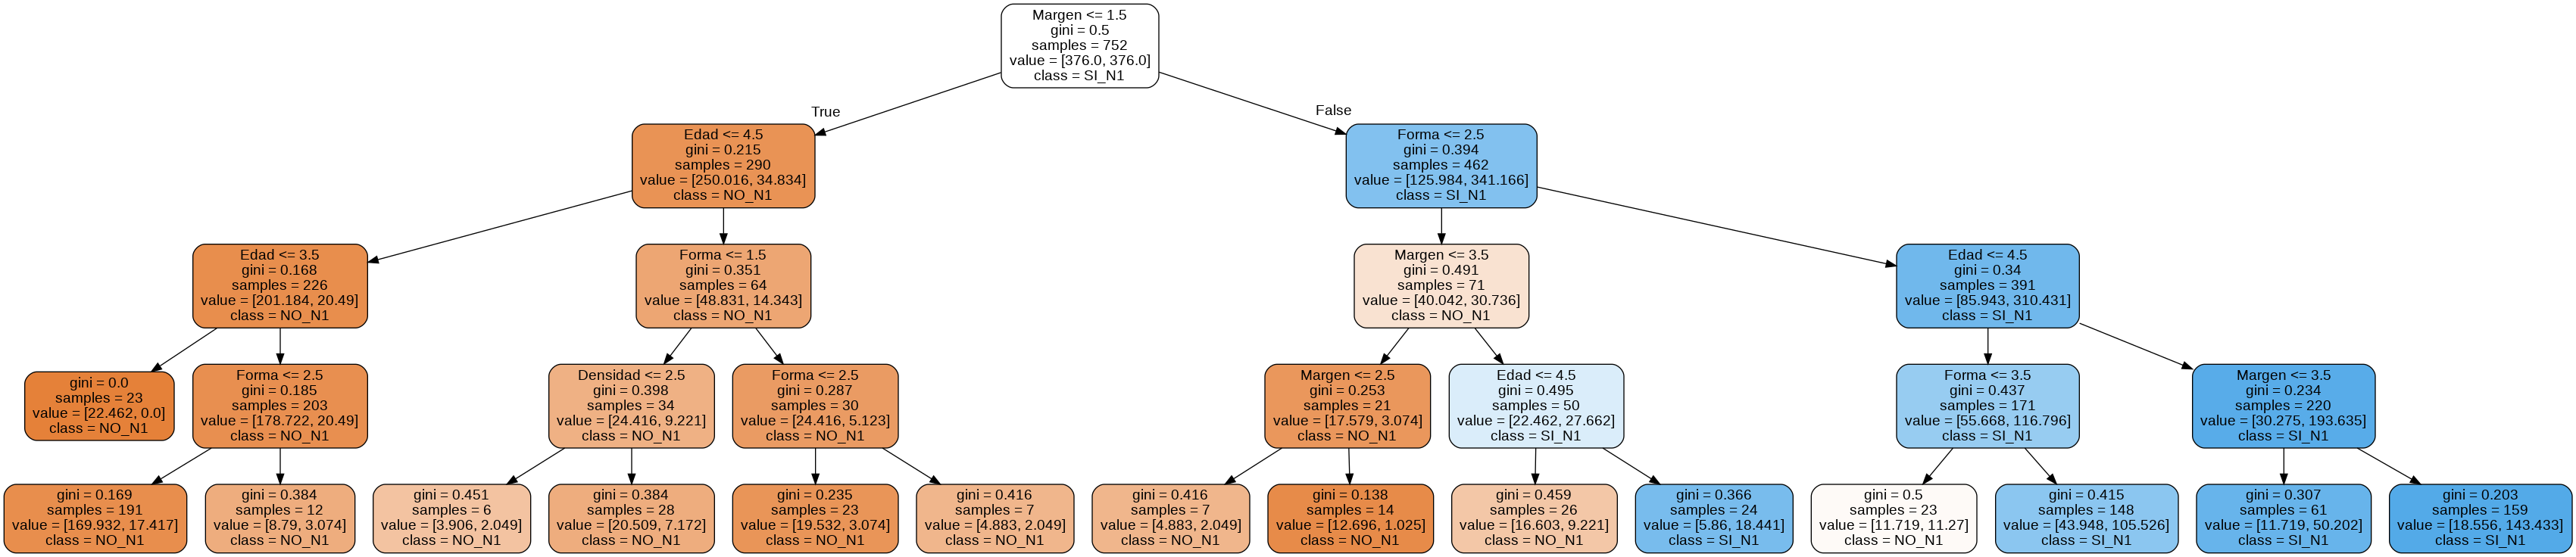

In [35]:
depth = 4
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=5,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced') 

# Ajustamos el modelo con los datos
decision_tree.fit(X_train, y_train)
y_pred_train = decision_tree.predict(X_train)

# exportar el modelo a archivo .dot y graficar
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = True,
                              feature_names = list(cancer_encoded.drop(['Severidad'], axis=1)),
                              class_names = ['NO_N1', 'SI_N1'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

# 7. Matriz de confusión.
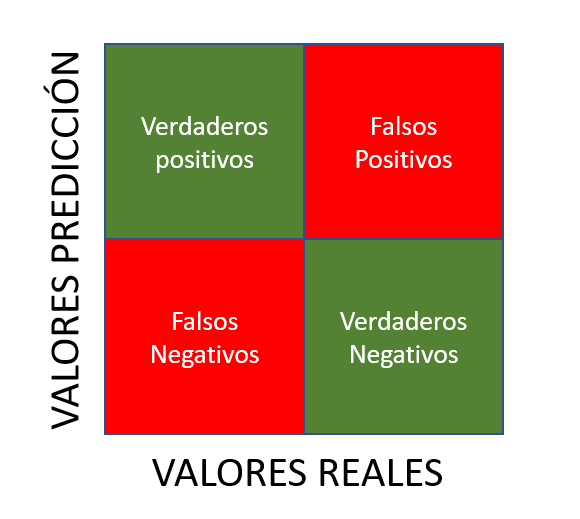

### Datos de entrenamiento.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


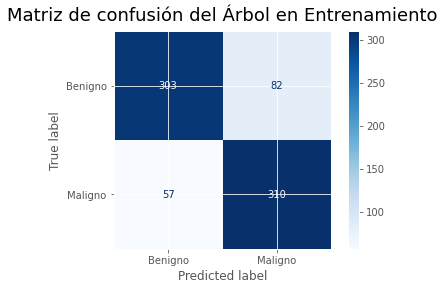

In [50]:
#Matriz de confuncion para Test
disp = plot_confusion_matrix(decision_tree, X_train, y_train,
                                 display_labels=['Benigno','Maligno'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del Árbol en Entrenamiento', y=1.02, size=18)

plt.show()

En la anterior gráfica se puede observar que aplicando el modelo en los **datos de entrenamiento** se obtienen 303 verdaderos positivos de los tumores benignos, en cambio se presentaron 82 casos de falsos positivos en detección de tumor benigno.
Ahora, para el caso de detección de tumores malignos se obtienen 310 casos verdaderos negativos y 57 casos de falsos negativos.

### Datos de prueba

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


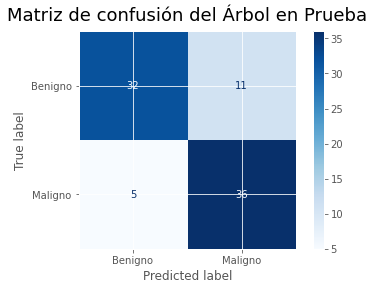

In [52]:
#Matriz de confuncion para Test
disp = plot_confusion_matrix(decision_tree, X_test, y_test,
                                 display_labels=['Benigno','Maligno'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del Árbol en Prueba', y=1.02, size=18)

plt.show()

En la anterior gráfica se puede observar que aplicando el modelo en los **datos de prueba** se obtienen 32 verdaderos positivos de los tumores benignos, en cambio se presentaron 11 casos de falsos positivos en detección de tumor benigno.
Ahora, para el caso de detección de tumores malignos se obtienen 36 casos verdaderos negativos y 5 casos de falsos negativos.

# 8. Métrica de exactitud

### Entrenamiento.

In [53]:
y_pred_train = decision_tree.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print("Train set accuracy: {:.2f}".format(acc_train))

Train set accuracy: 0.82


### Prueba.

In [54]:
y_pred_test = decision_tree.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 0.81


En general, la exactitud obtenida tanto para los datos de entrenamiento, como para los de prueba superan el 80%, lo que muestra que son considerablemente altos, mostrando un buen comportamiento del modelo.

# 9. F1-Score.

### Entrenamiento.

In [40]:
decoded_y_test = y_train
decoded_predictions = decision_tree.predict(X_train)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       385
           1       0.79      0.84      0.82       367

    accuracy                           0.82       752
   macro avg       0.82      0.82      0.82       752
weighted avg       0.82      0.82      0.82       752



### Prueba.

In [41]:
decoded_y_test = y_test
decoded_predictions = decision_tree.predict(X_test)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80        43
           1       0.77      0.88      0.82        41

    accuracy                           0.81        84
   macro avg       0.82      0.81      0.81        84
weighted avg       0.82      0.81      0.81        84



Observamos que el f1-score es bastante alto tanto para el set de prueba como de entrenamiento asi como tambien la precision, por lo que se puede afirmar que el modelo está entrenado correctamente. 

# 10. Clasificación bayesiana.

In [42]:
#Ajustando el modelo
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train,
    y_train
)
y_pred = gnb.predict(X_test)
 
print('Accuracy in training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy in test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))


Accuracy in training set: 0.80
Accuracy in test set: 0.80


### Matriz de confusión.

#### Entrenamiento.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


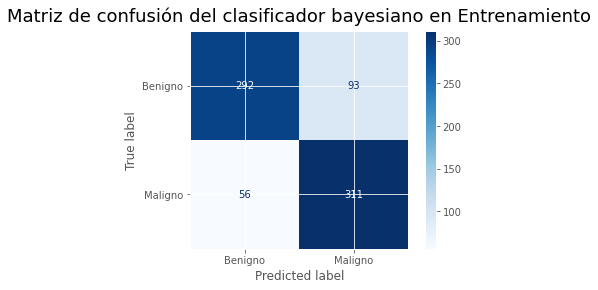

In [55]:
disp = plot_confusion_matrix(gnb, X_train, y_train,
                                 display_labels=['Benigno','Maligno'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del clasificador bayesiano en Entrenamiento', y=1.02, size=18)

plt.show()

En la anterior gráfica se puede observar que aplicando el modelo en los **datos de entrenamiento** se obtienen 292 verdaderos positivos de los tumores benignos, en cambio se presentaron 93 casos de falsos positivos en detección de tumor benigno.
Ahora, para el caso de detección de tumores malignos se obtienen 311 casos verdaderos negativos y 56 casos de falsos negativos.

#### Prueba.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


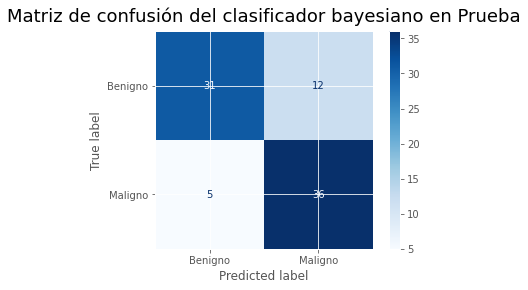

In [56]:
disp = plot_confusion_matrix(gnb, X_test, y_test,
                                 display_labels=['Benigno','Maligno'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matriz de confusión del clasificador bayesiano en Prueba', y=1.02, size=18)

plt.show()

En la anterior gráfica se puede observar que aplicando el modelo en los **datos de prueba** se obtienen 31 verdaderos positivos de los tumores benignos, en cambio se presentaron 12 casos de falsos positivos en detección de tumor benigno.
Ahora, para el caso de detección de tumores malignos se obtienen 36 casos verdaderos negativos y 5 casos de falsos negativos.

En comparación con el método anterior no existe mucha diferencia en los resultados obtenidos, pues aunque en la detección de verdaderos positivos para detectar tumores benignos sea menor en este método por unos cuantos métodos, en la detección de verdaderos negativos para la detección de tumores malignos es unos cuantos casos mayor.

### F1-Score

#### Entrenamiento.

In [45]:
decoded_y_test = y_train
decoded_predictions = gnb.predict(X_train)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       385
           1       0.77      0.85      0.81       367

    accuracy                           0.80       752
   macro avg       0.80      0.80      0.80       752
weighted avg       0.81      0.80      0.80       752



#### Prueba.

In [46]:
decoded_y_test = y_test
decoded_predictions = gnb.predict(X_test)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.72      0.78        43
           1       0.75      0.88      0.81        41

    accuracy                           0.80        84
   macro avg       0.81      0.80      0.80        84
weighted avg       0.81      0.80      0.80        84



Como se puede observar los resultados obtenidos mediante este método son bastante semejantes a los obtenidos anteriormente.

# 11. Análisis de resultados.

En primera instancia existe poca diferencia entre el árbo de decisión y el método de clasificación bayesiana. Sin embargo independiente del método de clasificación, se obtuvieron buenos resultados de detección de tumores benignos y malignos